# VC Project 2

## Imports

In [1]:
import cv2
import numpy as np
np.random.seed(42)
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from mnist import MNIST
import warnings
from IPython.display import display, Image
import os
import json
import sys
import torch
from torch import nn
from tqdm import tqdm
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

# ======================== Suppress Warnings ========================

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Defining functions

In [2]:
def loadImage(num):
    imgLoadSizeRatio = 0.1
    dataDir = 'imgs'

    img = cv2.imread(os.path.join(dataDir, f'{num}.jpg'))
    img = cv2.resize(img, (0, 0), fx = imgLoadSizeRatio, fy = imgLoadSizeRatio)
    return img

def render(image):
    images = [image]
    for i in range(len(images)):
        if images[i].dtype == np.float64:
            image = cv2.convertScaleAbs(images[i])
        else:
            image = images[i]
        if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
            if np.array_equal(image[:, :, 0], image[:, :, 2]):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_bytes = cv2.imencode('.png', image)[1].tobytes()
        display(Image(data=img_bytes))

def getActualPieceCount(imgID):
    df = pd.read_csv("lego_sets.csv")
    piece_count = df.loc[df['id'] == imgID, 'piece_count'].values[0]
    return piece_count 

def makeGuess(image_id, num_guess):
    piece_count = getActualPieceCount(image_id)
    num_legos_error = abs(num_guess - piece_count)
    
    if(num_legos_error > 0):
        print(f"Error in Lego Count - Guessed: {num_guess} | Actual: {piece_count} legos")
    else :
        print(f"Perfect ({num_guess}) Guess!")
        
    return piece_count, num_legos_error
    
def singleImagePredict(image_id):

    og_img = loadImage(image_id)
    
    print("Original Image")
    render(og_img)

    # TODO: EXECUTE MODEL
    num_guess = 0       
        
    return num_guess

def evaluate():
    
    total_lego_error = 0
    total_lego = 0
    error_count_ids = []

    for i in range(0, 50):
        print(f"\n======================== Image {i} ========================\n")
        num_legos_guess = singleImagePredict(i)
        piece_count, num_legos_error = makeGuess(i, num_legos_guess)
        
        if(num_legos_error > 0):
            error_count_ids.append(i)

        total_lego_error += num_legos_error
        total_lego += piece_count
    
    error_count_ids = set(error_count_ids)
    
    print(f"\n\n======================== TOTAL RESULTS ========================")   
    print(f"Total Lego Error: {total_lego_error} | {total_lego}")
    print("Num of images with count errors: " + str(len(error_count_ids)))
    print("Error images: " + str(error_count_ids))
    print("===============================================================")

In [3]:
# evaluate()

## Loading the data

In [4]:
imgs = []

for i in range(0, 50):
    img = loadImage(i)
    count = getActualPieceCount(i)
    imgs.append((img, count))
    
    # apply multiple transformations to the image to upsample the dataset
    
    # Rotation
    rotated_image_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    imgs.append((rotated_image_90, count))
    
    rotated_image_180 = cv2.rotate(img, cv2.ROTATE_180)
    imgs.append((rotated_image_180, count))
    
    rotated_image_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgs.append((rotated_image_270, count))
    
    # Flipping
    flipped_image = cv2.flip(img, flipCode=1)
    imgs.append((flipped_image, count))
    
    flipped_image = cv2.flip(img, flipCode=0)
    imgs.append((flipped_image, count))
    
    # Rotation + Flipping
    rotated_flipped_image = cv2.flip(rotated_image_90, flipCode=1)
    imgs.append((rotated_flipped_image, count))
    
    
# pick the first 80% of the images for training
train_imgs = imgs[:int(len(imgs)*0.8)]

# pick the remaining 20% of the images for validation
val_imgs = imgs[int(len(imgs)*0.8):]

print(len(train_imgs))
print(len(val_imgs))

280
70


## Defining the model

In [5]:
class CustomDataset(Dataset):
  def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
      image = self.images[idx]

      # Resize image to 224x224
      image = cv2.resize(image, (224, 224))

      # Apply transformations to the image
      if self.transform:
        image = self.transform(image)

      label = int(self.labels[idx])
      return (image, label)

In [6]:
train_images = [img[0] for img in train_imgs]
train_labels = [img[1] for img in train_imgs]
val_images = [img[0] for img in val_imgs]
val_labels = [img[1] for img in val_imgs]

batch_size = 64 # how many images are processed at a time
num_workers = 2 # how many processes are used to load the data

# Define transformations
data_aug = transforms.Compose([transforms.ToTensor()])

# Create dataset objects
training_data = CustomDataset(train_images, train_labels, transform=data_aug)
validation_data = CustomDataset(val_images, val_labels, transform=data_aug)

# Define data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Show one image
# plt.imshow(training_data[0][0][0,:,:], cmap='gray')

print(len(train_dataloader))
print(len(validation_dataloader))

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

5
2
Using cpu device


In [7]:

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.pool_size = 3
        self.nb_filters = 16
        self.kernel_size = 3

        self.layers = nn.Sequential(
            nn.Conv2d(3, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(85264, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32), # we have 32 classes to guess
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = ConvolutionalNeuralNetwork().to(device)
print(model)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=85264, out_features=64, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=64, out_features=32, bias=True)
  )
)


## Train

In [8]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)
    
    if num_batches == 0:
      print("No data in the dataloader")
      return 0.0, 0.0

    if is_train:
      model.train()
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Obtain prediction
          pred = model(X)
          
          # Obtain loss value
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          # Calculate final prediction
          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [9]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  
  best_val_loss = np.inf
  
  print("Start training...")
  
  for t in range(num_epochs):
    
      print(f"\nEpoch {t+1}")
      
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      
      if(train_acc > 0):
        val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      else :
        val_loss = 0
        val_acc = 0
        
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, "models/" + model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, "models/" + model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [10]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

Start training...

Epoch 1


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 3.485 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000

Epoch 2


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 3.488 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000

Epoch 3


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Train loss: 3.483 	 Train acc: 0.004


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


Val loss: 3.423 	 Val acc: 0.000

Epoch 4


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Train loss: 3.486 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000

Epoch 5


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Train loss: 3.483 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000

Epoch 6


100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Train loss: 3.485 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000

Epoch 7


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Train loss: 3.483 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000

Epoch 8


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Train loss: 3.484 	 Train acc: 0.004


100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Val loss: 3.423 	 Val acc: 0.000

Epoch 9


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Train loss: 3.489 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000

Epoch 10


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Train loss: 3.487 	 Train acc: 0.000
Val loss: 0.000 	 Val acc: 0.000
Finished


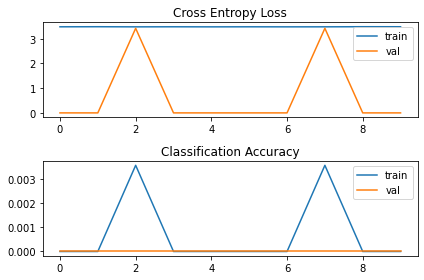

In [11]:
# Train network for 10 epochs
num_epochs = 10
model_name = 'custom_CNN'

loss_fn = nn.CrossEntropyLoss()
optimizer_custom = torch.optim.SGD(model.parameters(), lr=1e-2)

custom_train_history, custom_val_history = train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_custom)

plotTrainingHistory(custom_train_history, custom_val_history)

## Testing

In [12]:
# Load model
model = ConvolutionalNeuralNetwork().to(device)
checkpoint = torch.load("models/" + model_name + '_best_model.pth')
model.load_state_dict(checkpoint['model'])

# Test model
# test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
# print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

<All keys matched successfully>

In [13]:
def showErrors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
      
    plt.show()
    
# showErrors(model, test_dataloader)

## Pre-trained model

[Click here to check the pre-trained models that are available on torchvision.](https://pytorch.org/vision/0.9/models.html)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

100%|██████████| 5/5 [00:36<00:00,  7.22s/it]


Train loss: 3.493 	 Train acc: 0.025


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 2


100%|██████████| 5/5 [00:34<00:00,  6.93s/it]


Train loss: 3.435 	 Train acc: 0.036


100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 3


100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


Train loss: 3.498 	 Train acc: 0.032


100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 4


100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


Train loss: 3.454 	 Train acc: 0.054


100%|██████████| 2/2 [00:09<00:00,  4.63s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 5


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


Train loss: 3.470 	 Train acc: 0.025


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 6


100%|██████████| 5/5 [00:36<00:00,  7.21s/it]


Train loss: 3.507 	 Train acc: 0.021


100%|██████████| 2/2 [00:09<00:00,  4.63s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 7


100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


Train loss: 3.469 	 Train acc: 0.043


100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 8


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


Train loss: 3.509 	 Train acc: 0.029


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 9


100%|██████████| 5/5 [00:36<00:00,  7.25s/it]


Train loss: 3.461 	 Train acc: 0.039


100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


Val loss: 3.492 	 Val acc: 0.086

Epoch 10


100%|██████████| 5/5 [00:35<00:00,  7.08s/it]


Train loss: 3.477 	 Train acc: 0.018


100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Val loss: 3.492 	 Val acc: 0.086
Finished


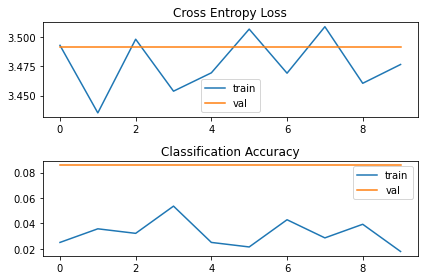

In [14]:
vgg = models.vgg16(pretrained=True)
vgg.to(device)

# set out_features of the last layer to 32
vgg.classifier[6] = nn.Linear(4096, 32)

print(vgg)

# Train network for 10 epochs
num_epochs = 10
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-2)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)